# Self Driving Vehicle Final project Group 15

### A software pipeline to detect vehicles in the following videos 

* test_video.mp4
* full project_video.mp4

Using the data set for training/testing of classifier which were provided in the project files.

## Importing all the required modules for the pipeline

In [1]:
import math
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import glob
import time
from collections import deque
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline



## Function Definition Block


#### Histogram of Oriented Gradients (HOG)

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):  
    if vis == True: # if visible==True, two outputs
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
   
    else:    # if vis==False,one output   
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features   

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0],size).ravel()
    color2 = cv2.resize(img[:,:,1],size).ravel()
    color3 = cv2.resize(img[:,:,2],size).ravel()
    return np.hstack((color1, color2, color3))

#### Computing the histogram of the color channels separately

In [4]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    channel1_hist=np.histogram(img[:,:,0], bins=nbins)
    channel2_hist=np.histogram(img[:,:,1], bins=nbins)
    channel3_hist=np.histogram(img[:,:,2], bins=nbins)
    # Concatenating the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Returning individual histograms, bin_centers and feature vector
    return hist_features

#### Extracting features from a list of images

In [5]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = [] #feature vectors list
    
    for file in imgs: # Iterating through the list of images
        file_features = []
        
        # Reading in each one by one
        image = mpimg.imread(file)
        
        # applying color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            
            # Applying color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:

            # Calling get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Appending the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### Converting the images to RGB2YCrCb colour format

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

#### Pre-pipeline

In [8]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255    
    img_tosearch = img[ystart:ystop,:,:]  
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Defining blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2   
    window = 64 # 64 was the orginal sampling rate
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1 #nblocks_per_window = (window // pix_per_cell)-1   
    cells_per_step = 2  # Instead of overlap, defining how many cells to step to process
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
   
    # Computing individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extracting HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))         
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)           
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),
                               (int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return draw_img, bboxes

#### Applying Sliding Window

In [9]:
def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    
    return out_img, bboxes

def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    
    return out_img, bboxes

#### Functions used for heat mapping

In [10]:
def add_heat(heatmap, bbox_list):   
   
    for box in bbox_list:# Iterating through list of boxes
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1    # Add += 1 for all pixels inside each bbo 
    return heatmap
    
def apply_threshold(heatmap, threshold): 
    heatmap[heatmap <= threshold] = 0 # pixels below the threshold are set zero
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1): # Iterating through all detected cars      
        nonzero = (labels[0] == car_number).nonzero() # Finding pixels with each car_number label value
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Defining a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6) # Drawing the box on the image
    return img

def get_heatmap(bboxes):
    threshold = 1
    heat = np.zeros_like(output_image[:,:,0]).astype(np.float) 
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    return heatmap

#### Video file processing

In [11]:
def detect_cars(image):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(image, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
   
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes) # Adding heat to each box in box list
    threshold = 1 
    heat = apply_threshold(heat, threshold)# Applying threshold to help remove false positives   
    current_heatmap = np.clip(heat, 0, 255)
    history.append(current_heatmap)  # Visualizing the heatmap when displaying 
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    
    for heat in history:
        heatmap = heatmap + heat

    # Finding the final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)    
    return draw_img

#### Functions used for plotting

In [ ]:
def four_fig_plot(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4"):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=15)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=15)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=15)
    ax4.imshow(image4)
    ax4.set_title(image4_exp, fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
def three_fig_plot(image1, image2, image3,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3"):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def two_fig_plot(image1, image2,  image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2, cmap='hot')
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def diplay_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Loading the Training Data Set

In [12]:
cars=glob.glob('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/vehicles/vehicles/**/*.png',
                       recursive=True)
notcars=glob.glob('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/non-vehicles/non-vehicles/**/*.png',
                           recursive=True)


#### Checking the Data Set

Number of car image data available : 8792
Number of non car image data available : 8968


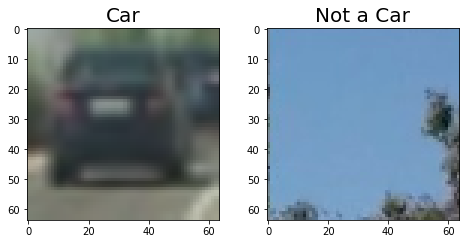

In [13]:
car_image_count = len(cars)
non_car_image_count = len(notcars)
print('Number of car image data available :', car_image_count)
print('Number of non car image data available :', non_car_image_count)

car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[0])

display_images(car_image, notcar_image, "Car", "Not a Car")

## Extracting features

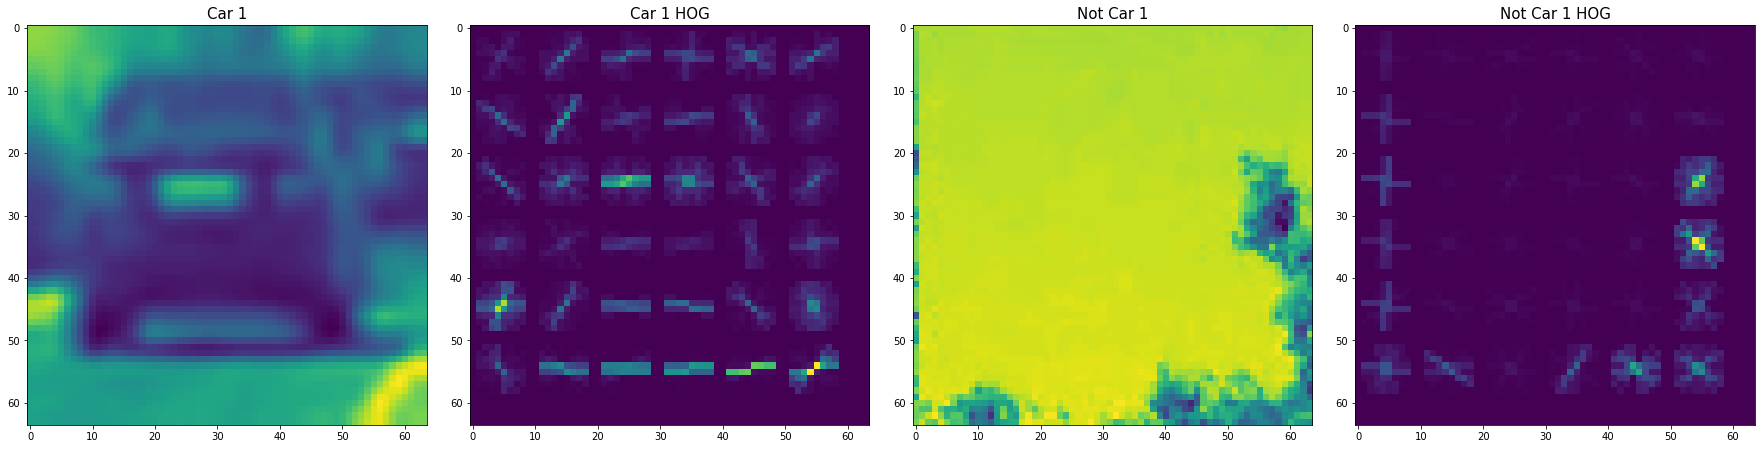

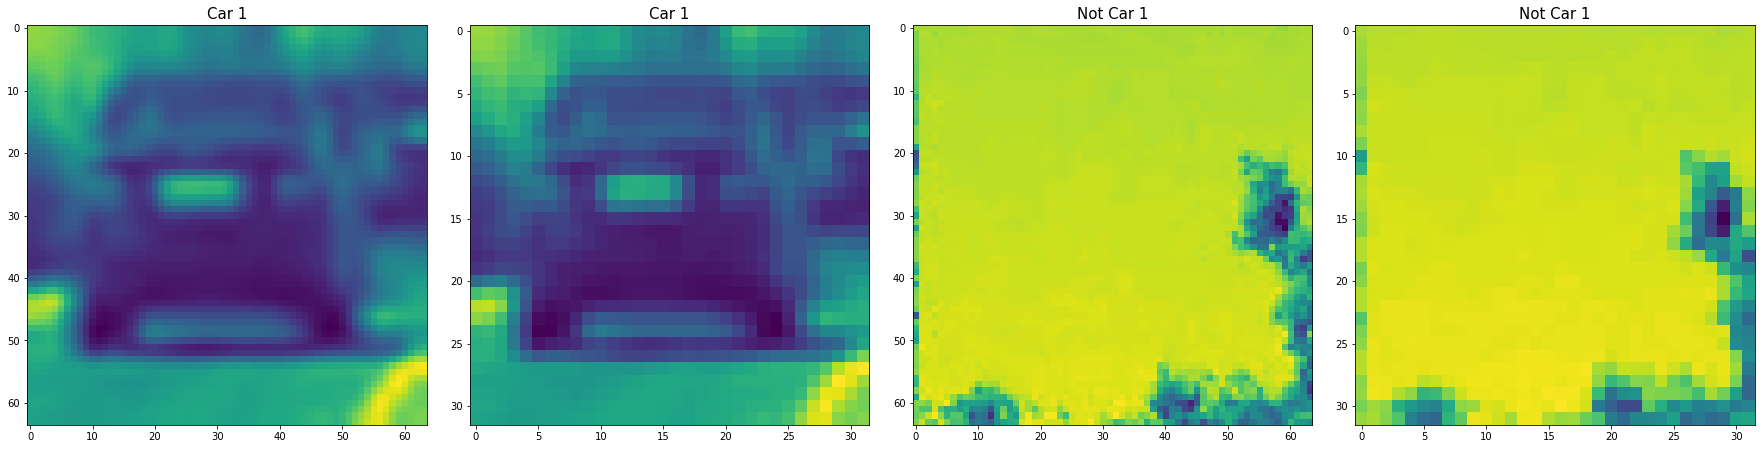

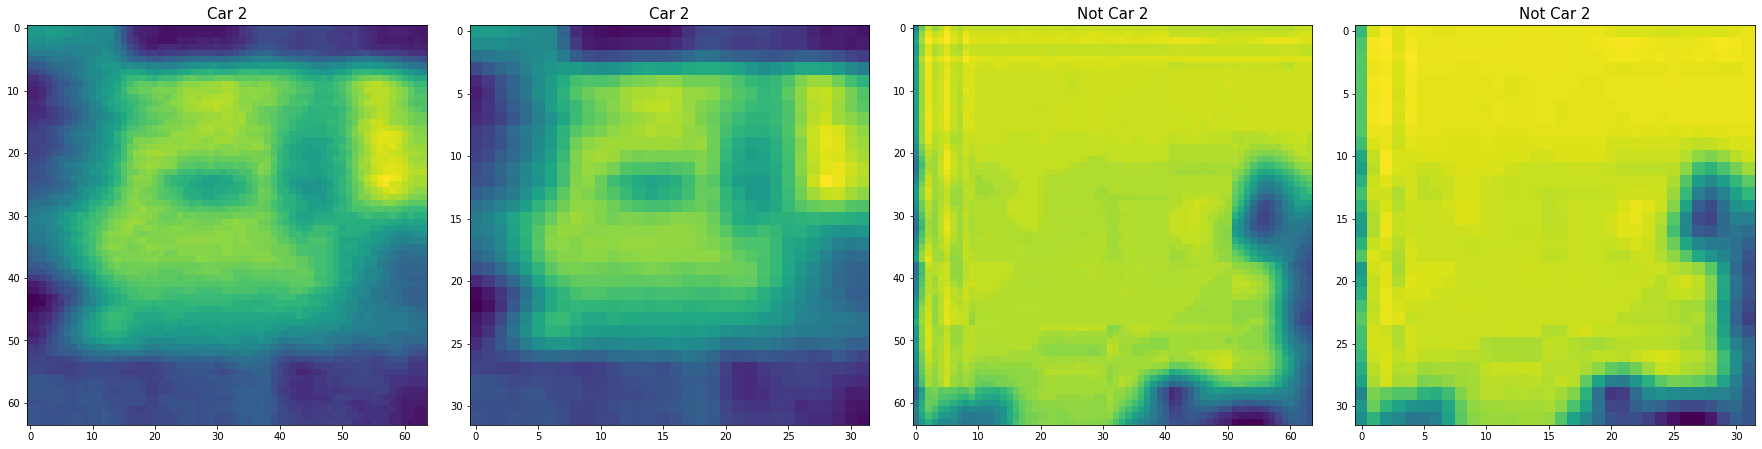

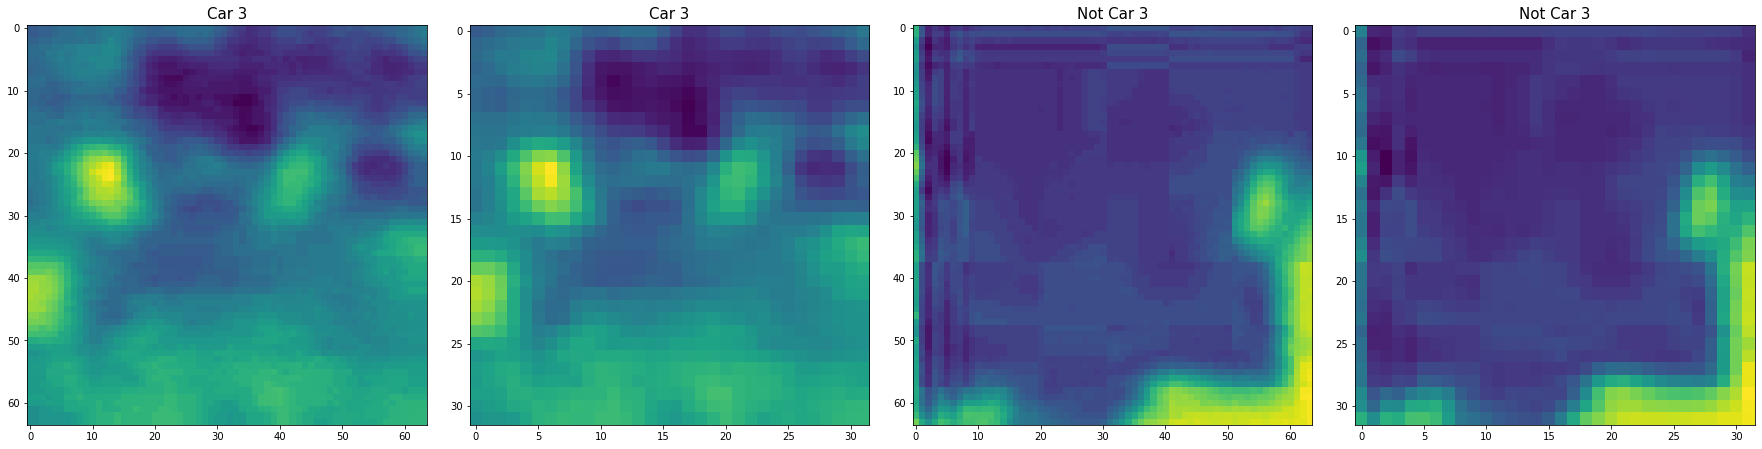

In [14]:
color_space = 'YUV' # YUV is a color model typically used as part of a color image pipeline
orient = 14  # orientation of HOG
pix_per_cell = 10 # pixels per cell
cell_per_block = 2 # cells per block

# Default values are used
hog_channel="ALL"
spatial_size=(32,32) # Spatial binning dimensions
hist_bins =32    # Number of histogram bins
spatial_feat=True # Spatial features on or off
hist_feat=True # Histogram features on or off
hog_feat=True # HOG features on or off

converted_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
car_1=converted_car_image[:,:,0]
car_2=converted_car_image[:,:,1]
car_3=converted_car_image[:,:,2]

converted_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YUV)
notcar_1=converted_notcar_image[:,:,0]
notcar_2=converted_notcar_image[:,:,1]
notcar_3=converted_notcar_image[:,:,2]

car_hog_feature, car_hog_image = get_hog_features(car_1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
notcar_hog_feature,notcar_hog_image=get_hog_features(notcar_1, orient, pix_per_cell, cell_per_block,vis=True, 
                                                     feature_vec=True)
car_1_features=cv2.resize(car_1,spatial_size)
car_2_features=cv2.resize(car_2,spatial_size)
car_3_features=cv2.resize(car_3,spatial_size)
notcar_1_features=cv2.resize(notcar_1,spatial_size)
notcar_2_features=cv2.resize(notcar_2,spatial_size)
notcar_3_features=cv2.resize(notcar_3,spatial_size)
#plotting the results   
four_fig_plot(car_1, car_hog_image, notcar_1, notcar_hog_image, "Car 1", "Car 1 HOG", "Not Car 1", "Not Car 1 HOG")    
four_fig_plot(car_1, car_1_features, notcar_1, notcar_1_features, "Car 1", "Car 1", "Not Car 1", "Not Car 1")    
four_fig_plot(car_2, car_2_features, notcar_2, notcar_2_features, "Car 2", "Car 2", "Not Car 2", "Not Car 2")    
four_fig_plot(car_3, car_3_features, notcar_3, notcar_3_features, "Car 3", "Car 3", "Not Car 3", "Not Car 3") 

## Classifier Training

In [15]:
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Vertical stacking of columns 
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Apply the scaler to X
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

#label vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#### Randomizing the training data and the test sets

In [16]:
rand_state = np.random.randint(0,50)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0])) # Using a linear SVC 
svc = LinearSVC() # Checking the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

# Checking the prediction time for a single sample
print(round(t2-t, 2), 'Seconds to train SVC')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time()

Using: 14 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 7368
21.81 Seconds to train SVC
Test Accuracy of SVC =  0.9918


## Car Finding (Pre-pipeline)


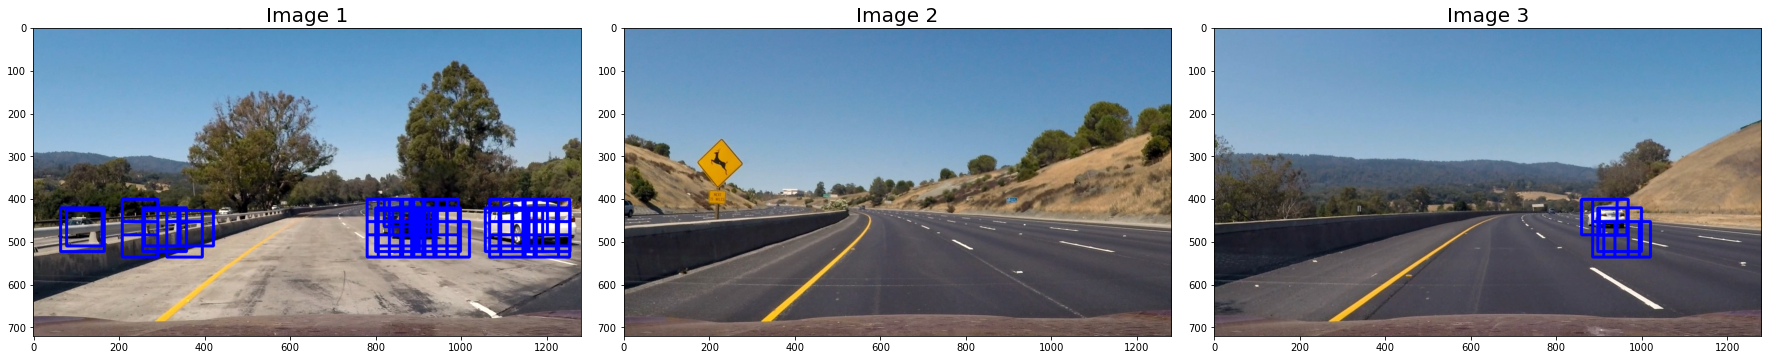

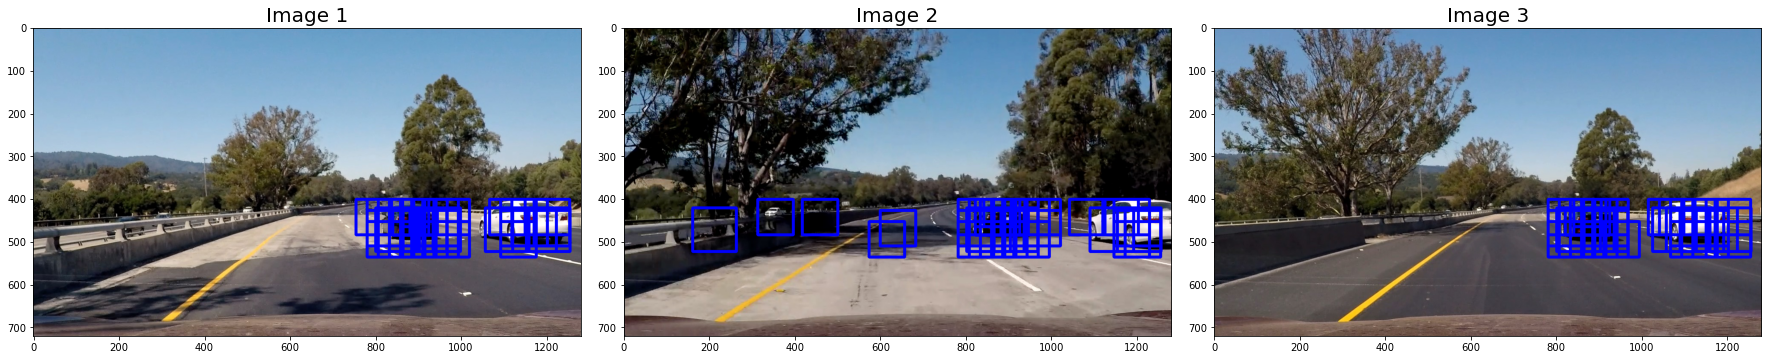

In [17]:
image1 = mpimg.imread('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/test_images/test1.jpg')
image2 = mpimg.imread('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/test_images/test2.jpg')
image3 = mpimg.imread('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/test_images/test3.jpg')
image4 = mpimg.imread('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/test_images/test4.jpg')
image5 = mpimg.imread('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/test_images/test5.jpg')
image6 = mpimg.imread('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/test_images/test6.jpg')

output_image1, bboxes1 = apply_sliding_window(image1, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image2, bboxes2 = apply_sliding_window(image2, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image3, bboxes3 = apply_sliding_window(image3, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image4, bboxes4 = apply_sliding_window(image4, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image5, bboxes5 = apply_sliding_window(image5, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image6, bboxes6 = apply_sliding_window(image6, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

image = mpimg.imread('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/test_images/test4.jpg')
draw_image = np.copy(image)
output_image, bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

three_fig_plot(output_image1, output_image2, output_image3)
three_fig_plot(output_image4, output_image5, output_image6)


## Creating Heatmap

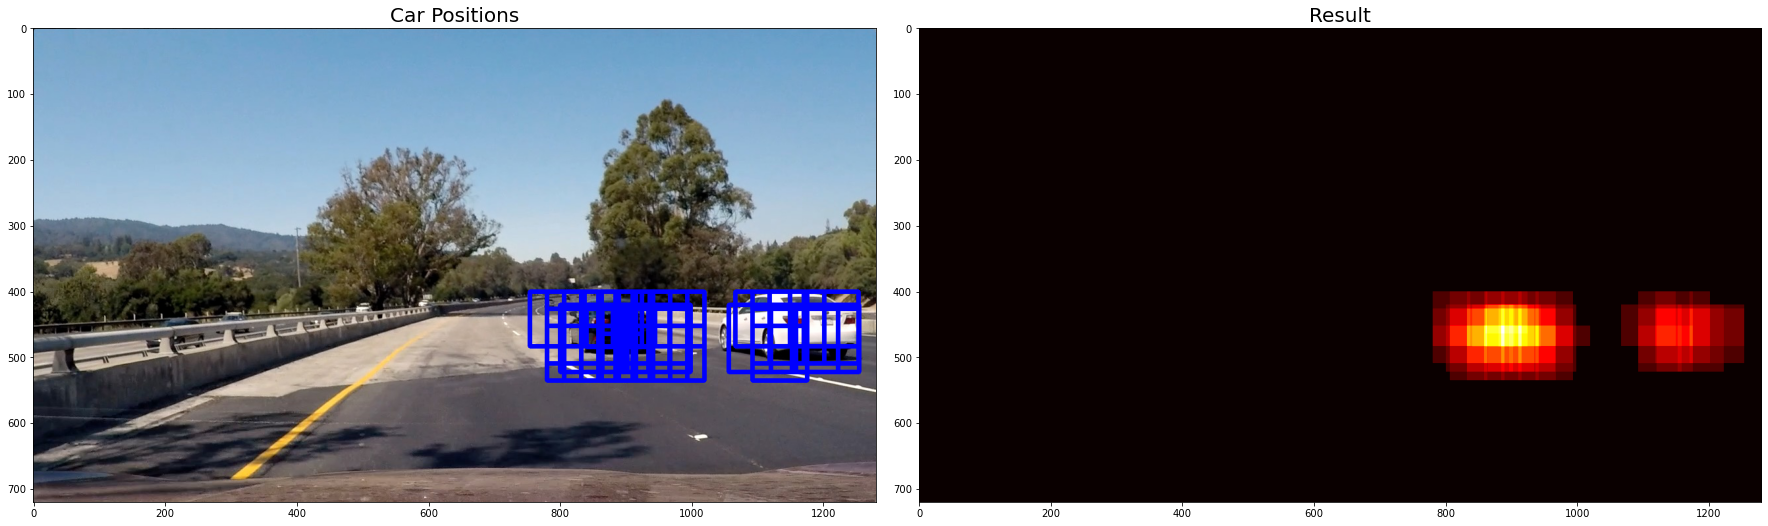

In [18]:
heat = np.zeros_like(output_image[:,:,0]).astype(np.float)
heat = add_heat(heat, bboxes)# Add heat to each box in box list
    
# Apply threshold to help remove false positives
threshold = 1 
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
two_fig_plot(output_image, heatmap, 'car finding', 'heatmap')



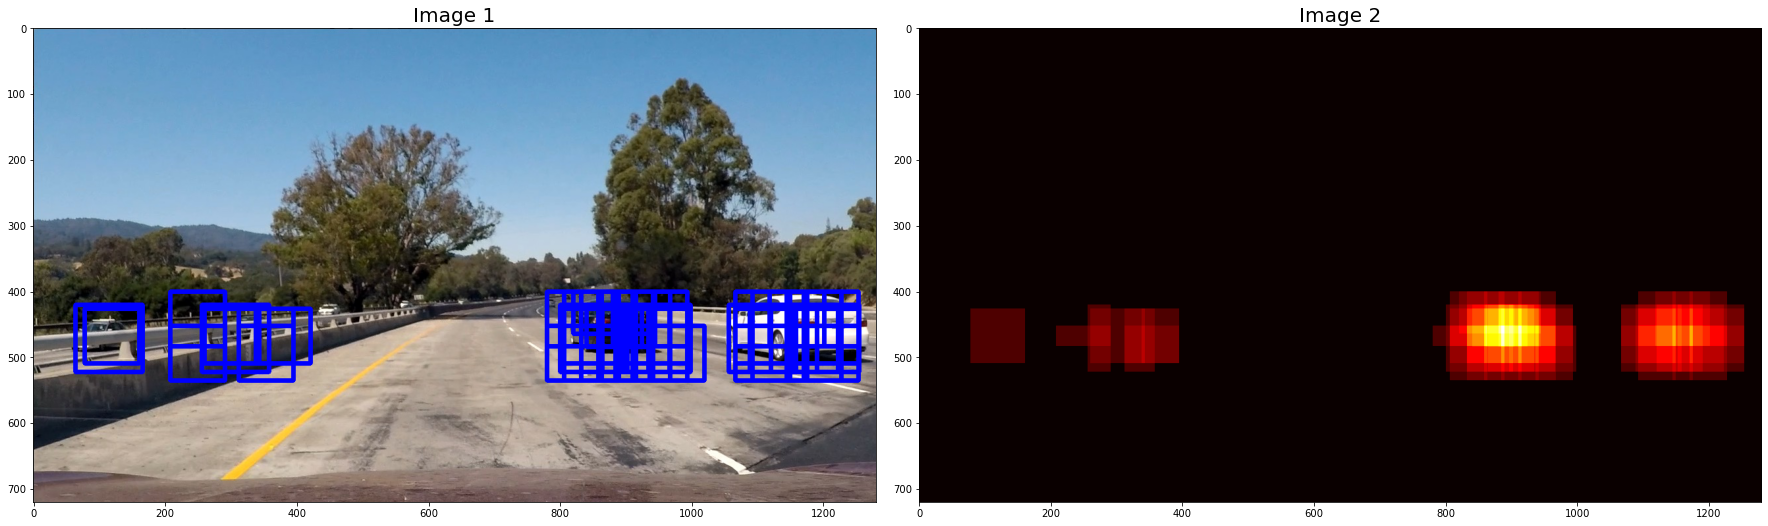

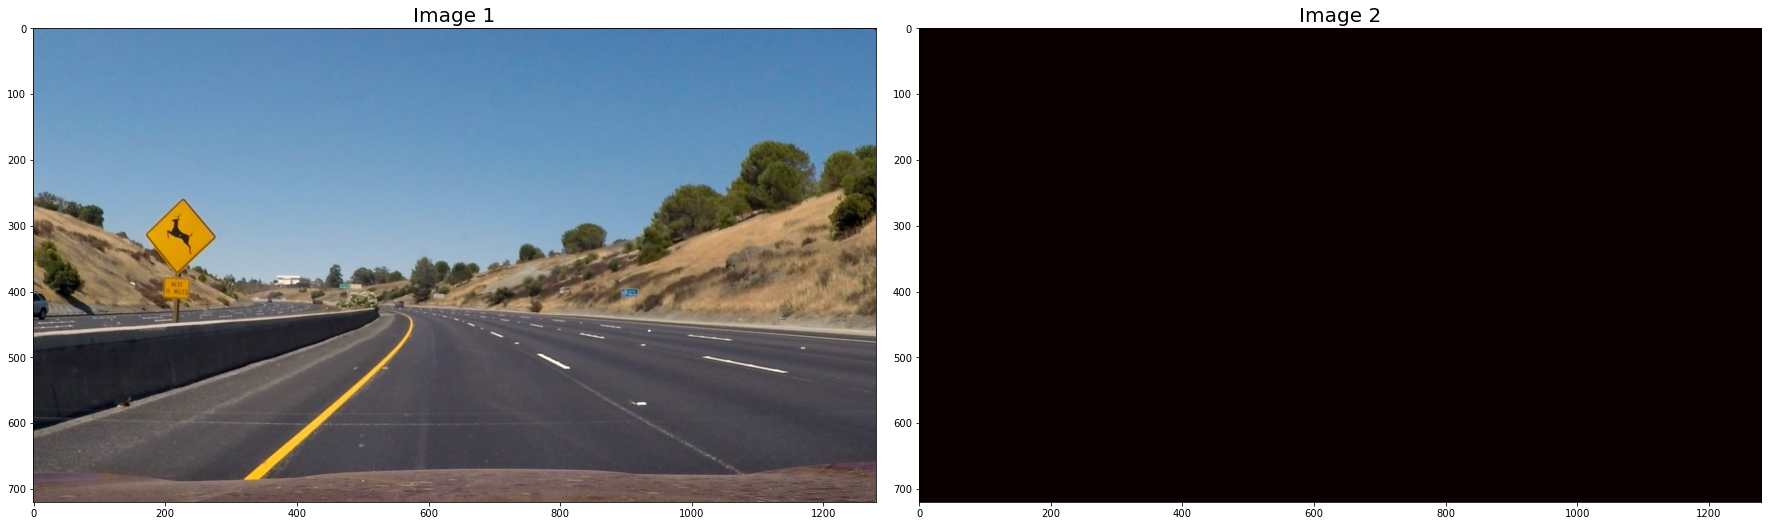

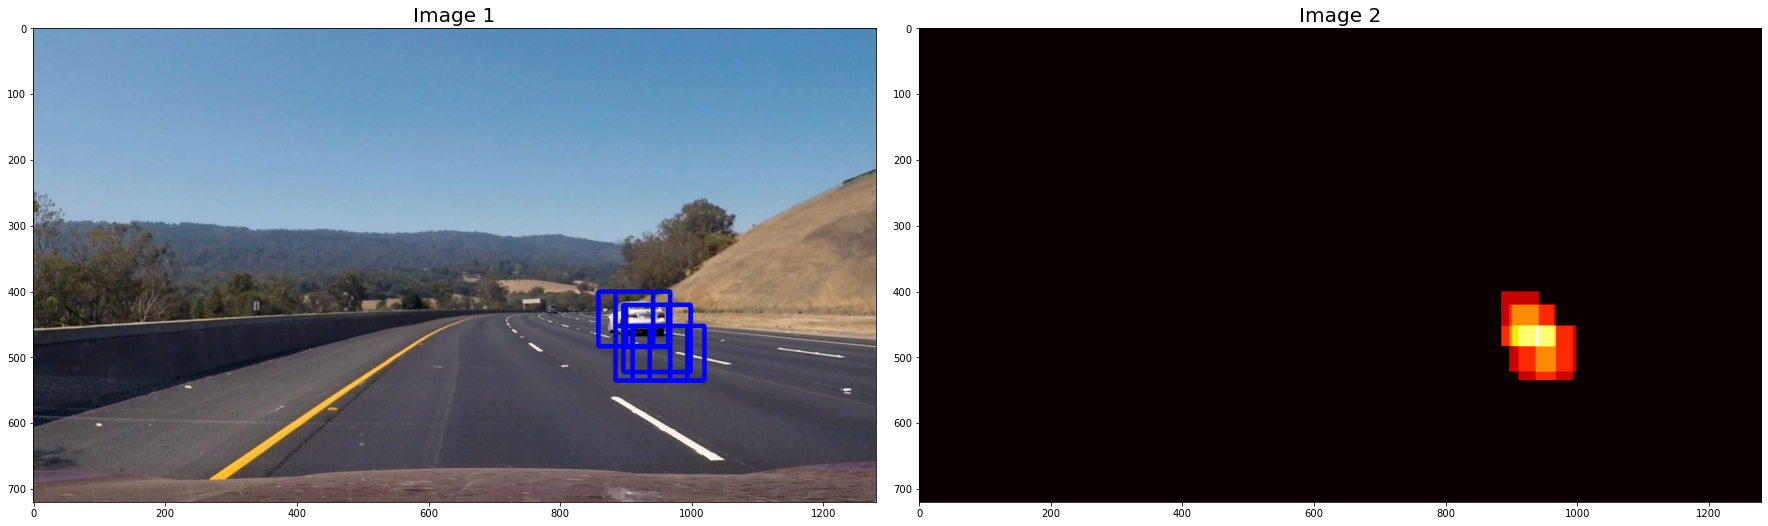

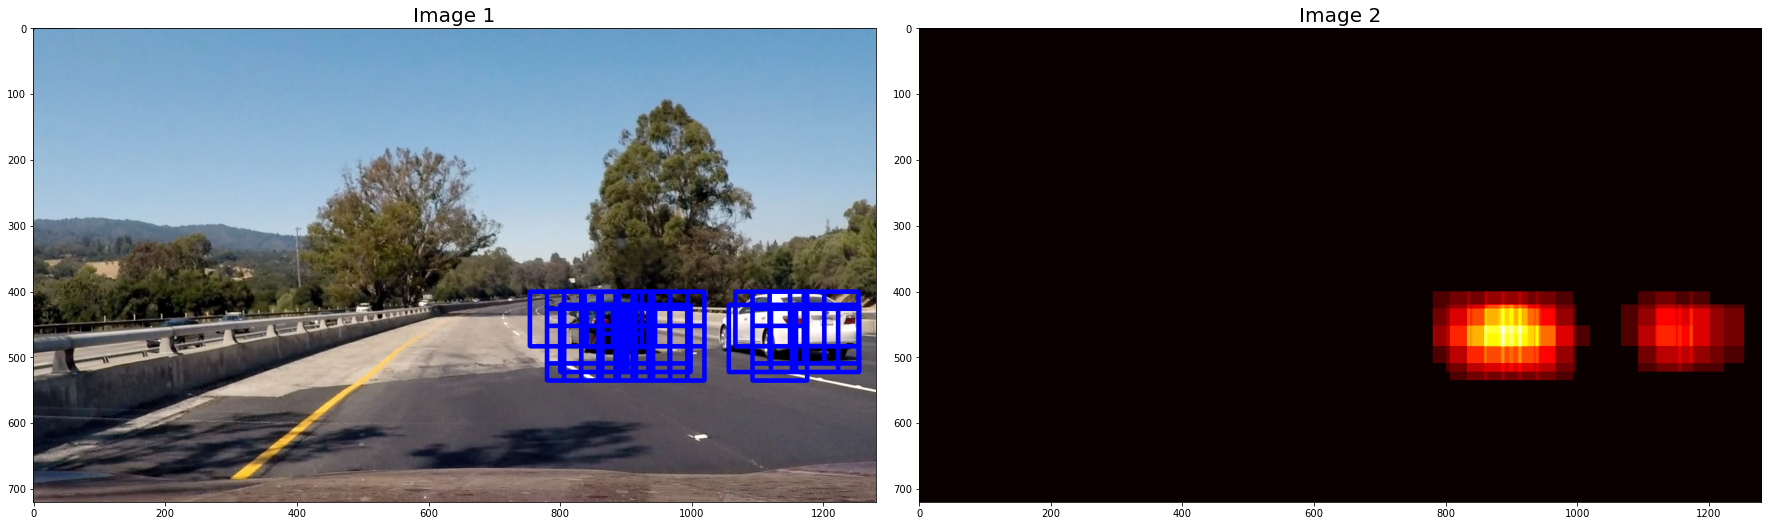

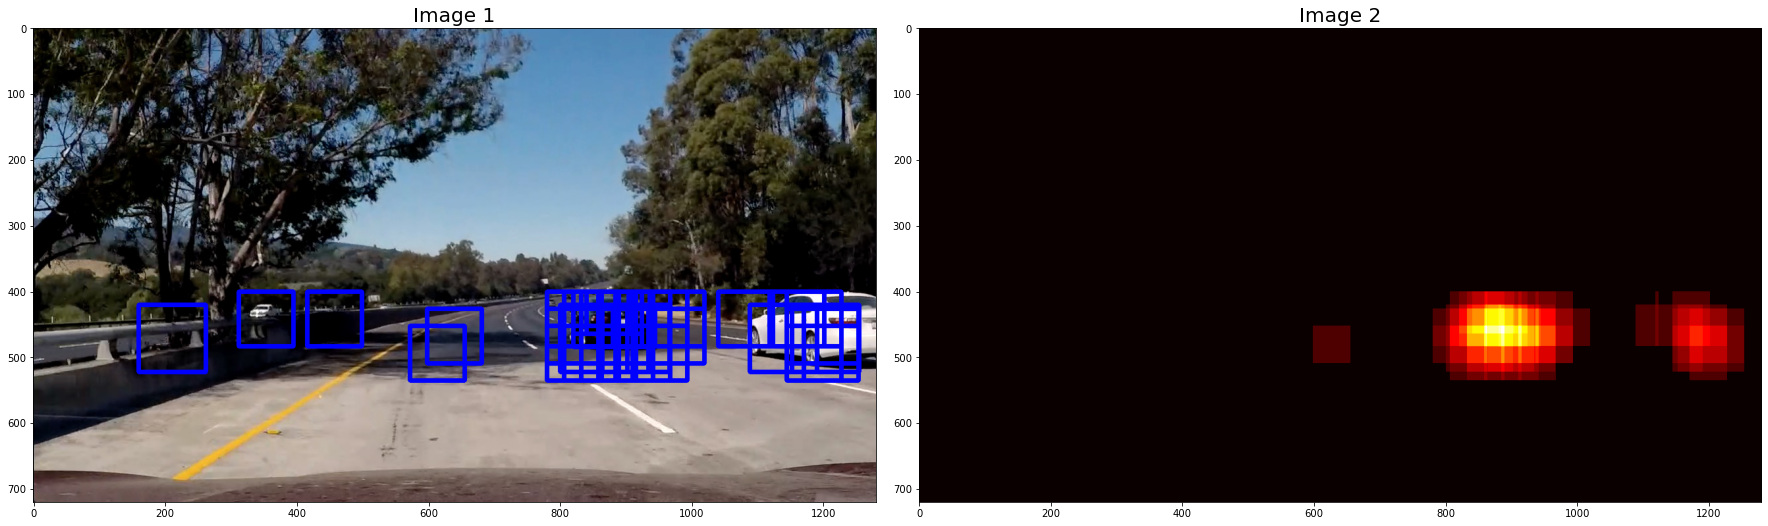

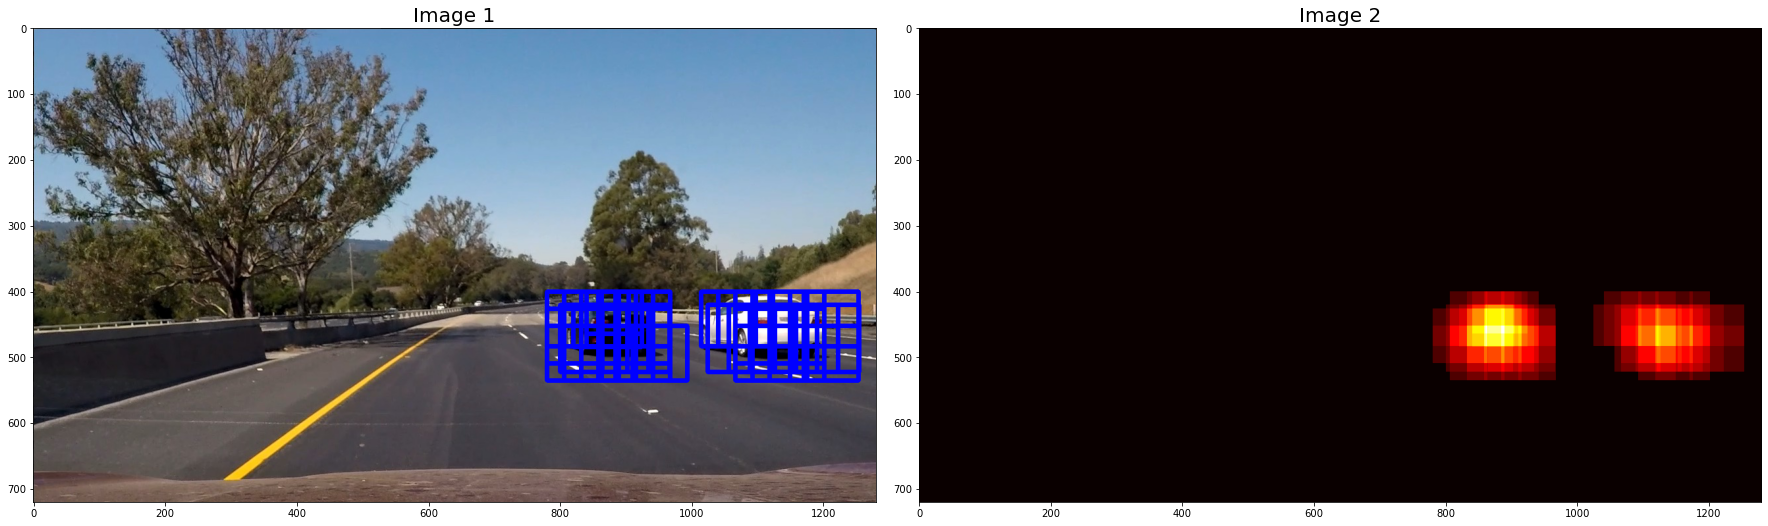

In [25]:
def two_fig_plot(image1, image2,  image1_exp='car finding', image2_exp='heatmap'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2, cmap='hot')
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)

heatmap1 = get_heatmap(bboxes1)
heatmap2 = get_heatmap(bboxes2)
heatmap3 = get_heatmap(bboxes3)
heatmap4 = get_heatmap(bboxes4)
heatmap5 = get_heatmap(bboxes5)
heatmap6 = get_heatmap(bboxes6)
two_fig_plot(output_image1, heatmap1)
two_fig_plot(output_image2, heatmap2)
two_fig_plot(output_image3, heatmap3)
two_fig_plot(output_image4, heatmap4)
two_fig_plot(output_image5, heatmap5)
two_fig_plot(output_image6, heatmap6)

## Creating labelled Image

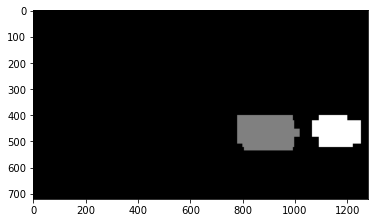

In [20]:
plt.imshow(labels[0], cmap='gray')

## Drawing bounding boxes

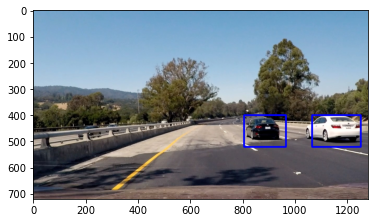

In [22]:
history = deque(maxlen = 8)
img = detect_cars(image)
plt.imshow(img)

## Processing Test Video

In [23]:
history = deque(maxlen = 8)
output = 'test_video_output.mp4'
clip = VideoFileClip('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/test_video.mp4')
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

Moviepy - Building video test_video_output.mp4.
Moviepy - Writing video test_video_output.mp4



Moviepy - Done !
Moviepy - video ready test_video_output.mp4
Wall time: 42 s


## Processing Project Video

In [24]:
history = deque(maxlen = 8)
output = 'project_video_output.mp4'
clip = VideoFileClip('C:/Users/balaj/OneDrive/Desktop/SDV final project/Master files/project_video.mp4')
video_clip = clip.fl_image(detect_cars)
%time video_clip.write_videofile(output, audio=False)

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 21min 9s
